# Cours 9: Introduction à Keras

Arthur Llau, arthur@flowlity.com

**Plan** : 
- Benchmark
- Définition de l'architecture d'un modèle
- Layers, Activation & Optimizer
- Callbacks
- NLP tricks
- Vision tricks


## I - Introduction - Benchmark : classification & régréssion

In [1]:
import warnings
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.datasets import make_classification,make_regression
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
X,y = make_classification(n_samples = 100000, n_features = 100, shuffle = True, random_state = 1234)
X_tr,X_te,y_tr,y_te = train_test_split(X, y, random_state = 2019) 

In [3]:
X,y = make_regression(n_samples = 100000, n_features = 100, shuffle = True, random_state = 1234, noise = True)
S_tr,S_te,s_tr,s_te = train_test_split(X, y, random_state = 2019) 

**1.1** Evaluer une régréssion logistique avec la métrique AUC sur le jeu de test correspondant.

**1.2** Evaluer une régréssion linéaire avec la métrique MAE sur le jeu de test correspondant.

## Que trouve-t'on dans Keras ?


Keras est une API de deep learning, interfacable avec plusieurs framework comme Tensorflow, CNTK, Theano ou MxNet

Points positifs :
-  Facilité de prise en main, user-friendly, ressemble à sklearn
-  Modulaire : on construit le graphe couche par couche ou comme un graphe 
-  Permet de mettre en place rapidement des tests
-  Grosse communauté donc plein de papiers implémentés
-  Plus rapide que torch en prédiction

## II - Définir l'architecture d'un modèle

![](networkx.png)

Il existe deux méthodes pour définir un modèle :
- Sequential : couche par couche
- API : architecture arbitraire


In [6]:
from keras import layers
from keras import models

## Sequential, la plus simple
#input_shape taille d'entrée (nombre de features dans le cas de données tabulaires),
#si image (longueur,largeur,nb_couche)
model = models.Sequential()
model.add(layers.Dense(4, input_shape = (100,)))
model.add(layers.Dense(1, activation= 'sigmoid'))


Using TensorFlow backend.


In [7]:

#API qui permet de concatener des layers
input_matrix = layers.Input((100,))
x = layers.Dense(4)(input_matrix)
output = layers.Dense(1)(x)
model = models.Model(input_matrix, output)

![exemple](model.png)

In [8]:
object_a = layers.Input(shape=(280, 256))
object_b = layers.Input(shape=(280, 256))

shared_layer = layers.LSTM(64)
#On construit deux layers indépendant
layer_a = shared_layer(object_a)
layer_b = shared_layer(object_b)
#On les concatene
merged_vector = layers.concatenate([layer_a, layer_b], axis=-1)
#On ajoute l'output
predictions = layers.Dense(1, activation='sigmoid')(merged_vector)

model_concat = models.Model(inputs=[object_a, object_b], outputs=predictions)


Une fois le modèle construit, il faut compiler. C'est-à-dire lui spécifier la fonction objectif (loss) et l'algorithme d'optimisation permettant de mettre à jour les poids du réseau. (optimizer)



In [9]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['acc'])


On peut afficher un résumé de l'architecture avec la commande suivante :

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________


*Pourquoi a-t'on 404 paramètres dans la couche d'entrée ?*

On dispose  de 4 neurones, et 100 features, donc le nombre de paramètres est égale à nb neurones * nb features + nb neurones (biais)

On peut sauvegarder l'architecture comme une image grâce à plot_model : 

In [11]:

from keras.utils import plot_model
plot_model(model, to_file='model_init.png', show_shapes=True, show_layer_names=True)

![](model_init.png)

Il ne reste plus qu'à lui faire apprendre des données.

In [12]:
%%capture
history = model.fit(X_tr,y_tr, epochs = 100, batch_size = 10000)
# Batch = nombre d'échantillons que l'on envoie dans le réseau à chaque itération
# Epoch = nombre de forward et backward totaux que l'on souhaite réaliser

On peut récupérer les valeurs de loss et de la métrique durant l'évaluation

Text(0, 0.5, 'metric')

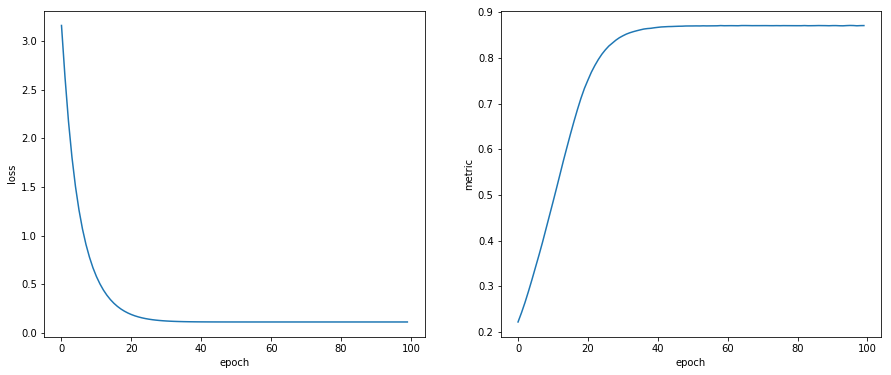

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range(100),history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(range(100),history.history['acc'])
plt.xlabel('epoch')
plt.ylabel('metric')


Pour **prédire**, rien de plus simple. model.predict(X)

## III - Layers, Activations & Optimizer

In [14]:
from keras.layers import *
from keras.models import Sequential


Pour des données tabulaires il y a principalement trois layers importants : Dense, Dropout, Activation.

In [15]:
#Dense : Fully connected layer
Dense(units = 30, activation=None, use_bias=True, kernel_initializer='glorot_uniform')
print("""units : nombre de cellules

activation : fonction d'activation""")

units : nombre de cellules

activation : fonction d'activation


In [16]:
#Dropout : Regularization en faisant sauter des neurones pendant l'apprentissage
Dropout(rate = 0.3, seed=None)
print("""rate : taux de dropout""")

rate : taux de dropout


In [17]:
model = Sequential()

#La couche d'activation est équivalente à l'option activation dans une couche
model.add(Dense(64, activation = 'relu'))
# équivalent à 
model.add(Dense(64))
model.add(Activation(activation='relu'))

On trouve quatre activations principales :
- linear : le signal n'est pas transformé
- tanh : $\frac{e^x−1}{e^x+1}$retourne une valeur entre -1 et 1  
- sigmoid :  $ f(x)=\frac{1}{1 + e^{- x}}$, retourne une valeur entre 0 et 1
- relu : $max(0,x)$, on garde uniquement ce qui nous intéresse 

La denière couche du réseau est celle qui nous donne l'output désiré. Sa dimension, ainsi que son activation doivent être choisi pour répondre à la problématique voulu.

**Classification binaire** :

- nombre de neurones : 1
- activation : sigmoid $ f(x)=\frac{1}{1 + e^{- x}}$
- loss : binary_crossentropy



**Classification multiclasses** :
    
- nombre de neurones : nombre de classes
- activation : softmax
- loss : categorical_crossentropy

    
    

**Régréssion** :
    
- nombre de neurones : 1
- activation : linéaire
- loss : toute loss différentiable

    
    

Le choix de l'algorithme d'optimisation est toujours une grande question. L'utilisation de l'algorithme peut être réalisé de deux façons.

In [18]:
from keras.optimizers import SGD
#Avec les paramètres par défault
model.compile(loss = 'mean_squared_error', optimizer='sgd')

## Ou bien pour pouvoir customiser l'algorithme
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)

Voici un rapide récapitulatif des principaux algorithmes d'optimisation  :
-  SGD, le plus classique, fluctue autour du minimum
-  RMSprop, bon choix pour les réseaux récurrent
-  Adam, efficace dans la majorité des cas (https://arxiv.org/abs/1412.6980v8)


**Question 1** : Dans le cas de la classification binaire construire un modèle permettant d'atteindre la valeur de la régréssion logistique, en l'évaluant sur le jeu de test correspondant. Et afficher les valeurs de loss et de métrique.

In [19]:
from keras.models import *
from keras.layers import *


**Question 2** : Dans le cas de la régréssion construire un modèle permettant d'atteindre la valeur de la régréssion linéaire, en l'évaluant sur le jeu de test correspondant. Et faites une figure des valeurs de loss et de métrique.

In [25]:
from keras import backend as K
K.clear_session()

Peut-on affirmer que nos modèles obtiennent réellement ces scores ?

Absolument pas, on ne les valide pas !
Il y a alors deux manière de rajouter un jeu de validation.

N'avons nous pas oublier quelque chose avant de faire nos modèles ? 


Normaliser les données ! Avec des scalings de différents type par exemple !

### IV. Callbacks

Les callbacks permettent de réaliser des opérations, comme sauver les poids du réseaux, ou utilier un Cycling LR finder.

In [32]:
from keras.callbacks import *

checkpoint  = ModelCheckpoint('weights.h5', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


In [33]:
history = model2.fit(S_tr, s_tr, validation_data=(S_te,s_te), batch_size = 1000, epochs = 10, callbacks=[checkpoint, earlystop, reduce_lr])

Train on 75000 samples, validate on 25000 samples
Epoch 1/10
75000/75000 [==============================] - 0s 2us/step - loss: 88.8715 - mean_absolute_error: 88.8715 - val_loss: 88.3656 - val_mean_absolute_error: 88.3656

Epoch 00001: saving model to weights.h5
Epoch 2/10
75000/75000 [==============================] - 0s 2us/step - loss: 88.8272 - mean_absolute_error: 88.8272 - val_loss: 88.3601 - val_mean_absolute_error: 88.3601

Epoch 00002: saving model to weights.h5
Epoch 3/10
75000/75000 [==============================] - 0s 2us/step - loss: 88.8123 - mean_absolute_error: 88.8123 - val_loss: 88.3741 - val_mean_absolute_error: 88.3741

Epoch 00003: saving model to weights.h5
Epoch 00003: early stopping


## V. NLP & RNN


Layers utiles pour les RNN : LSTM & GRU (voir cours d'E. Scornet)

In [11]:
#couche d'embedding permettant de vectorizer un ensemble de tokens
#Renvoie des entiers positif comme un vecteur dense, ce sont rien de plus que poids mis à jour lors des backprop
Embedding(input_dim = 300, output_dim = 10)
print('input_dim: nombre de mots uniques', "\nouput_dim : taille de l'embedding", "\ninput_lenght :taille maximale d\'une phrase")

input_dim: nombre de mots uniques 
ouput_dim : taille de l'embedding 
input_lenght :taille maximale d'une phrase


In [34]:
#GRU
GRU(units = 50, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False)
print("return_sequence : retourner le dernier élement de la séquence ou la séquence entière")

return_sequence : retourner le dernier élement de la séquence ou la séquence entière


In [35]:
#GRU
LSTM(units = 50, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, implementation=1, return_sequences=False)
print("return_sequence : retourner le dernier élement de la séquence ou la séquence entière")

return_sequence : retourner le dernier élement de la séquence ou la séquence entière


In [36]:
#Faster si cuda disponible
CuDNNGRU(units = 50)
CuDNNLSTM(units = 50)

In [37]:
#Flatten : matrice to vector
Flatten()

In [38]:
#BatchNormalization : normalization by each batch to set the feature map mean close to 0
BatchNormalization()

**Comment devons nous transformer des données textuelles ?**

In [1]:
## On verra ça plus en détail 

On doit les tokenizer puis les utiliser comme on le souhaite.

In [39]:
from keras.preprocessing.text import text_to_word_sequence
# define the document
text = 'Il fait beau et chaud.'
# tokenize the document
result = text_to_word_sequence(text)
print(result)

['il', 'fait', 'beau', 'et', 'chaud']


In [7]:
#Et pour directement transformer un corpus
from keras.preprocessing.text import Tokenizer
sentences_train = ['il fait beau et chaud','Paris est une belle ville', 'Paris est beau']

tokenizer = Tokenizer(num_words = 5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
#nombre maximum de mots
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
print(X_train) # Que se passe-t'il ?
print(tokenizer.word_index)

[[4, 5, 1, 6, 7], [2, 3, 8, 9, 10], [2, 3, 1]]
{'beau': 1, 'paris': 2, 'est': 3, 'il': 4, 'fait': 5, 'et': 6, 'chaud': 7, 'une': 8, 'belle': 9, 'ville': 10}


In [41]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train)
print(X_train) # Que se passe-t'il ?

[[4 5 1 6 7]
 [0 0 2 3 8]
 [0 0 2 3 1]]


La couche d'input change pour être un embedding, c'est-à-dire une couche de vectorization permettant d'utiliser des données textuelles.


Word embedding: technique permettant de représenter chaque mot d'un dictionnaire par un vecteur de nombres réels.

2 phrases:
- "Hope to see you soon"
- "Nice to see you again"
On assigne un entier unique à chaque mot, dans l'ordre d'apparition.
- [0, 1, 2, 3, 4]
- [5, 1, 2, 3, 6]

Si on veut entrainer notre reseau sur cette première couche il faut alors spécifier:
__Embedding(7, 2, input_length=5)__
7 correspond au nombre de token distincts (vocab size), 2 indique la dimension de l'embedding, et l'input_length la longueur de chaque sequence.


In [42]:
model = Sequential()
vocab_size =len(tokenizer.word_index) + 1 #l'index 0 est utilisé par keras, on ne peut pas l'utiliser
model.add(Embedding(vocab_size, 16))
model.add(LSTM(32))
model.add(Dense(1))

## VI - Exercices

In [1]:
import pandas as pd

from keras.layers import *
from keras.models import *
from keras.optimizers import *

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


/home/arthur/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Exercice 1** : Avec les données des prix des maisons, construire un nnet permettant de résoudre le problème de régréssion. Evaluer les performances avec la rmse. Tester plusieurs architectures, que constatez-vous ? Comparer les performances avec un autre modèle.

In [44]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [45]:
y_train = train.SalePrice
y_test = test.SalePrice

train.drop(['Id','SalePrice'], axis = 1, inplace = True)
test.drop(['Id','SalePrice'], axis = 1, inplace = True)

In [46]:
for c in train.select_dtypes(object):
    
    train[c] = train[c].fillna('__NC__')
    test[c] = test[c].fillna('__NC__')
    
    enc = LabelEncoder()
    enc.fit(list(train[c])+ list(test[c]))
    train[c] = enc.transform(train[c])
    test[c] = enc.transform(test[c])

train.fillna(-9000, inplace = True)
test.fillna(-9000, inplace = True)

In [47]:
ss = StandardScaler()
ss.fit(list(train.values)+list(test.values))
train = ss.transform(train)
test = ss.transform(test)

In [48]:
#Je définis la métrique pour être utilisable avec Keras
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

**Exercice 2**: Regarder les layers disponible pour les problématiques de vision. Puis construire le réseau correspondant à l'image suivante (VGG16).

![](vgg16.png)